# ステップ9 拡散モデルの実装

## 9.1 U-Net
- 拡散モデルで使用されるニューラルネットワークは, 数式で $\epsilon_\mathbf{\theta}(\mathbf{x_t}, t)$ と表される. 
    - 入力：ノイズデータの$\mathbf{x_t}$と時刻$t$.
    - 出力：*-ノイズ--を予測.
- ひとまず, ノイズデータ$\mathbf{x_t}$のみを入力とし, それが完成した後に, 時刻$t$を追加したモデルを実装する.

### 9.1.1 U-Netとは
- U-Net
    - 元々は「セマンティック・セグメンテーション」のためのモデル.
    - 入力：(C, H, W)の形状の画像データ.
        - C: チャネル数(RGB画像では3)
        - H: 画像の高さ
        - W: 画像の幅
    - 出力: (D, H, W)の形状のテンソル
        - D: 分類するクラスの数
- 拡散モデルでは, C=Dとして, 入出力のチャネル数を同じに設定する. 

![U-Net_network](U-Net_network.png)

> At each downsampling step we double the number of feature channels. 

-"ダウンサンプリングの各ステップで, 特徴チャネルの数を**2倍**にします. "*

> Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution ("up-convolution") that halves the number of feature channels...

*"拡張経路の各ステップは, 特徴マップのアップサンプリングと, それに続く特徴チャネルの数を**半分**にする2x2の畳み込み（「アップコンボリューション」）で構成されます…"*

> a large number of feature channels, which allow the network to propagate context information to higher resolution layers. 

*...多数の特徴チャネルがあることで、ネットワークは **コンテキスト情報（文脈情報）** を高解像度の層へ伝搬させることができる。*

### 9.1.2 U-Netの実装
- ここでは, 1x28x28のサイズのMNISTを想定した, シンプルなU-Netの実装を行う.
![U-Net_network_1x28x28](U-Net_network_1x28x28.png)
    - 2段階の縮小ステージと2段階の拡大ステージを持つ
    - 各ステージでは, 2層の畳み込み層による処理を行う
---
このU-Netを実装するにあたり, `ConvBlock`クラスを実装する.

![](ConvBlock.png)


In [1]:
import torch
from torch import nn

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()  # 親クラスの初期化
        self.convs = nn.Sequential( # 複数の層を直列に接続
            nn.Conv2d(in_ch, out_ch, 3, padding=1), # 3x3の畳み込み層
            nn.BatchNorm2d(out_ch),                 # バッチ正規化
            nn.ReLU(),                              # 活性化関数ReLU
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.convs(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()

        self.down1 = ConvBlock(in_ch, 64)
        self.down2 = ConvBlock(64, 128)
        self.bot1 = ConvBlock(128, 256)
        self.up2 = ConvBlock(128+256, 128)
        self.up1 = ConvBlock(128+64, 64)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x):
        x1 = self.down1(x) # 1段目の畳み込み
        x = self.maxpool(x1) # 1段目のプーリング
        x2 = self.down2(x) # 2段目の畳み込み
        x = self.maxpool(x2) # 2段目のプーリング
        x = self.bot1(x) # ボトムの畳み込み

        # -----------------------------------------------------
        # x の形状：(N, C, H, W)
        # x1の形状：(N, I, H, W)
        # dim = 1 により, 2番目の次元（チャンネル数）で結合される
        # -----------------------------------------------------
        x = self.upsample(x) # 2段目のアップサンプリング
        x = torch.cat([x, x2], dim=1)   # **スキップ接続**
        x = self.up2(x) # 2段目の畳み込み
        x = self.upsample(x) # 1段目のアップサンプリング
        x = torch.cat([x, x1], dim=1)   # **スキップ接続**
        x = self.up1(x) # 1段目の畳み込み
        x = self.out(x) # 出力層
        return x

今回の実装では, 
- サイズを**縮小**する処理：Maxプーリング(`nn.MaxPool2d`)として実装

    →テンソルのサイズは1/2    
- サイズを**拡大**する処理：バイリニア補完によるアップサンプリング(`nn.Upsample`)を使う.

    →テンソルのサイズは2倍
- スキップ接続：`torch.cat([x, x1], dim=1)`として実装.
    - `torch.cat()`関数により, テンソルを結合.
    - `dim=1`により, 連結する次元を指定.
    - 今回の場合, `(N, C+I, H, W)`

先ほどの図において, 下記の部分を`ConvBlock`として実装した. 

![](U-Net_network_1x28x28_with_convBlock.png)

---

### U-Netクラスを使う

In [3]:
model = UNet()
x = torch.randn(10, 1, 28, 28) # dummy input
y = model(x) # forward pass
print(y.shape) # (10, 1, 28, 28) <- 入力と出力が同じ形状

torch.Size([10, 1, 28, 28])


### 9.2 正弦波位置エンコーディング

拡散モデルでは, 整数である時刻`t`をニューラルネットワークで効果的に扱うために, ベクトルへ変換する必要がある. その手法として, ここでは**正弦波位置エンコーディング**が用いられる. 

---
#### 9.2.1 正弦波位置エンコーディングとは

これは, 元々「Transformer」モデルで有名になった手法であり, 整数`t`を`D`次元のベクトル($\mathbf{v} = (\mathbf{v_0}, \mathbf{v_1}, \cdots \mathbf{v_{D-1}})$)に変換する. 変換後のベクトルの`i`番目の要素は, `i`が偶数か奇数かに応じて, 以下の式で計算される(`10000`はハイパーパラメータ). 

$$\mathbf{v_i} = \begin{cases}   \sin(\frac{t}{10000^{i/D}}) & (\text{iが偶数のとき}) \\ \cos(\frac{t}{10000^{i/D}}) & (\text{iが奇数のとき}) \end{cases}$$

これは, 「**正弦波を使って位置情報を, 周期的な特性を持つ`sin`と`cos`関数を通じてエンコーディングする**」ことを意味し, 位置情報（時刻）の相対的な差異や周期的なパターンが明確に表現され, モデルは相対的な位置関係をより効果的に学習できる. 

---
#### 9.2.2 正弦波位置エンコーディングの実装

実装は2つの関数に分けて行われる. 

- **単一データ用 (`_pos_encoding`)**: 1つの時刻`t`を受け取り, 上記の数式に基づいて`D`次元のベクトルを返す. 
- **バッチデータ用 (`pos_encoding`)**: 時刻のバッチ（テンソル）`ts`を受け取り, forループで各時刻に対して`_pos_encoding`を呼び出し, 結果をまとめて返す. 

コードでは, `torch.arange()`でインデックス`i`のテンソルを生成し, スライス記法（例: `v[0::2]`）でベクトルの偶数・奇数インデックスにアクセスして, それぞれ`sin`と`cos`の計算を適用する. 

In [4]:
import torch

def _pos_encoding(t, output_dim, device='cpu'):
    """
    一つの時刻tに対する位置エンコーディングを計算する関数.
    """
    D = output_dim  # Dは出力の次元数
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)
    div_term = 10000 ** (i/D)

    v[0::2] = torch.sin(t / div_term[0::2]) # i= 0,    2,    4,    ...
    v[1::2] = torch.cos(t / div_term[1::2]) # i=    1,    3,    5, ...
    return v 

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 使用例
t = 1
D = 16
v = _pos_encoding(t, D)
print(v.shape) # torch.Size([16]) 

torch.Size([16])


In [6]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import imageio

D = 8
ts = np.arange(0, 100, 1)
dims = np.arange(D)
png_files = []

for idx, t in enumerate(ts):
    v = _pos_encoding(t, D)
    v_np = v.cpu().numpy()
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={"height_ratios":[1, 2]})

    # --- 上段: 次元ごとのエンコーディング ---
    ax = axs[0]
    ax.scatter(dims[0::2], v_np[0::2], color='skyblue', label='Even (sin)', s=50)
    ax.scatter(dims[1::2], v_np[1::2], color='coral', label='Odd (cos)', s=50)
    # ax.plot(dims[0::2], v_np[0::2], 'o-', color='skyblue', label='Even (sin)')
    # ax.plot(dims[1::2], v_np[1::2], 'o-', color='coral', label='Odd (cos)')
    ax.set_title(f"Positional Encoding Vector for t={t}, D={D}")
    ax.set_xlabel("Dimension (i)")
    ax.set_ylabel("Value")
    ax.set_xticks(dims)
    ax.set_ylim(-1.2, 1.2)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='lower right')

    # --- 下段: 各次元の位相を単位円上に描画 ---
    ax2 = axs[1]
    circle = plt.Circle((0,0), 1, fill=False, color='gray', linestyle='dashed')
    ax2.add_artist(circle)
    # 各次元ごとにthetaを計算して単位円上に点を描画
    i_arr = np.arange(D)
    div_term = 10000 ** (i_arr / D)
    theta = t / div_term
    x = np.cos(theta)
    y = np.sin(theta)
    scatter = ax2.scatter(x, y, c=i_arr, cmap='viridis', s=60, label='Dimensions')
    # カラーバー
    cbar = plt.colorbar(scatter, ax=ax2, orientation='vertical', label='Dimension (i)')
    ax2.set_xlim(-1.2, 1.2)
    ax2.set_ylim(-1.2, 1.2)
    ax2.set_aspect('equal')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.set_xlabel("cos(phase)")
    ax2.set_ylabel("sin(phase)")
    ax2.set_title("Phase on Unit Circle")
    # 中心線
    ax2.axhline(0, color='gray', linewidth=0.8, linestyle=':')
    ax2.axvline(0, color='gray', linewidth=0.8, linestyle=':')

    plt.tight_layout()
    png_path = f"frame_{idx:03d}.png"
    fig.savefig(png_path)
    png_files.append(png_path)
    plt.close(fig)

# GIFとして保存
with imageio.get_writer('pos_encoding.gif', mode='I', duration=0.1) as writer:
    for png_path in png_files:
        image = imageio.imread(png_path)
        writer.append_data(image)

# PNGを削除
for png_path in png_files:
    os.remove(png_path)

print('GIF saved as pos_encoding.gif and PNG files deleted')

C:\Users\kyoro\AppData\Local\Temp\ipykernel_36916\2026687960.py:64: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(png_path)


GIF saved as pos_encoding.gif and PNG files deleted


#### **単位円グラフ(下段)**
1. 次元 `i` が小さい点（濃い紫）は, `t`が少し進むだけで円上を**速く回転**.

    これは高周波の波に対応し, `t=10`と`t=11`のような**近い位置の微妙な差異**を捉えることができる.
2. 次元 `i` が大きい点（明るい黄色）は, `t`が進んでも**非常にゆっくり**と回転. 

    これは低周波の波に対応し, `t=10`と`t=50`のような**遠い位置の大きな差異**を捉える役割を持つ. 

3. このように`t`が一つ進むとき, 点は単位円上で決まった角度だけ回転する.

    例えば, `t=10`と`t=11`のベクトルの差は, `t=10`と`t=50`のベクトルの差よりも小さい. すなわち,  **相対的な関係性** を表現している. 

#### **ベクトル全体のグラフ(上段)**
1. 上段のベクトル全体のグラフを見ると, 時刻`t`が進むにつれて, `sin`と`cos`の時間変化として. $v_i$は変化する. 
2. 「点の配置パターン」は, どの時刻`t`を切り取っても **常に固有(ユニーク)** である. 

結果として, 全ての`t`に対して**他とは異なる一意のベクトル**が割り当てられ, モデルは異なる時刻を明確に区別. 

#### **結果**
このようにして, 正弦波位置エンコーディングは **「位置情報の相対的な差異や周期的なパターンが明確に表現」** することができ, モデルは **「系列データ中の相対位置の関係性をより効果的に学習」** できるようになる

In [7]:
# バッチデータを処理する正弦波位置エンコーディング
def pos_encoding(ts, output_dim, device='cpu'):
    batch_size = len(ts)
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(ts[i], output_dim, device)
    return v

In [8]:
v = pos_encoding( torch.tensor([1, 2, 3]), 16 )
print(v.shape) 
print(v)

torch.Size([3, 16])
tensor([[ 8.4147e-01,  8.4601e-01,  3.1098e-01,  9.8423e-01,  9.9833e-02,
          9.9842e-01,  3.1618e-02,  9.9984e-01,  9.9998e-03,  9.9998e-01,
          3.1623e-03,  1.0000e+00,  1.0000e-03,  1.0000e+00,  3.1623e-04,
          1.0000e+00],
        [ 9.0930e-01,  4.3146e-01,  5.9113e-01,  9.3742e-01,  1.9867e-01,
          9.9368e-01,  6.3203e-02,  9.9937e-01,  1.9999e-02,  9.9994e-01,
          6.3245e-03,  9.9999e-01,  2.0000e-03,  1.0000e+00,  6.3246e-04,
          1.0000e+00],
        [ 1.4112e-01, -1.1597e-01,  8.1265e-01,  8.6104e-01,  2.9552e-01,
          9.8580e-01,  9.4726e-02,  9.9858e-01,  2.9995e-02,  9.9986e-01,
          9.4867e-03,  9.9999e-01,  3.0000e-03,  1.0000e+00,  9.4868e-04,
          1.0000e+00]])


***
### 9.2.3 U-Netへの組み込み
最後に, U-Netに正弦波位置エンコーディングを組み込む(前節で実装した, `ConvBlock`クラスに正弦波位置エンコーディングを取り入れる). 前節で実装したU-Netを下図に示す. 

**前節で実装したU-Net**

![](U-Net_with_Convblock.png)

--- 
**U-Net全体のアーキテクチャ**

`pos_encoding`からの情報が, U-Netを構成する5つの`ConvBlock`それぞれに入力として渡される. 

![](U-Net_with_position_encoding.png)

--- 
**新しい`ConvBlock`の内部処理図**

![](new_ConvBlock_process.png)

- `x`: 特徴マップ
- `v`: 時刻情報(正弦波位置エンコーディングによってベクトル化された時刻`t`の情報)
- `MLP`: 多層パーセプトロン

    ここでは, **全結合層からなるニューラルネットワーク**を指す. `v`を特徴マップ`x`と足し算ができるように, チャネル数`C`と同じ次元数のベクトルになるよう変換. 

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), # 3x3の畳み込み層
            nn.BatchNorm2d(out_ch),                 # バッチ正規化
            nn.ReLU(),                              # 活性化関数ReLU
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
        )
        self.mlp = nn.Sequential(   # 全結合層
            nn.Linear(time_embed_dim, in_ch),     # 時間埋め込みをチャンネル数に変換
            nn.ReLU(),
            nn.Linear(in_ch, in_ch),              # in_chの次元数のベクトルへ変換
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)         # 画像特徴マップxのチャネル数(次元数)へ変換
        v = v.view(N, C, 1, 1)  # 整形
        y = self.convs(x+v)     # 時刻情報vが画像の特徴マップxの全ピクセルに対して加算
        return y

エンコードされた時刻ベクトルは, U-Netを構成する5つの`ConvBlock`モジュール全てに組み込まれる(図 "U-Net全体のアーキテクチャ" 参照). 

1.  **MLPによる変換**: `ConvBlock`の内部では, まずMLP（多層パーセプトロン）が, エンコードされた`D`次元の時刻ベクトル`v`を, 画像の特徴マップ`x`のチャネル数と同じ次元数に変換する. 
2.  **加算**: 変換後の時刻ベクトルは`(N, C, 1, 1)`の形状に変形され, ブロードキャスト機能を利用して画像の特徴マップ`x`（形状`(N, C, H, W)`）に加算される. 
3.  **畳み込み**: 時刻情報が加算された`x + v`が, `ConvBlock`内の2回の畳み込み層で処理される. 
--- 
この変更に伴い, `UNet`クラスの`forward`メソッドを更新.

引数として`timesteps`を受け取り, `pos_encoding`関数を呼び出して時刻ベクトル`v`を生成し, 各`ConvBlock`に渡すように実装.

In [10]:
class UNet(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=16):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128+256, 128, time_embed_dim)
        self.up1 = ConvBlock(128+64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x, timesteps):
        v = pos_encoding(timesteps, self.time_embed_dim, device=x.device)
        x1 = self.down1(x, v) # 1段目の畳み込み
        x = self.maxpool(x1) # 1段目のプーリング
        x2 = self.down2(x, v) # 2段目の畳み込み
        x = self.maxpool(x2) # 2段目のプーリング

        x = self.bot1(x, v) # ボトムの畳み込み

        x = self.upsample(x) # 2段目のアップサンプリング
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, v) # 2段目の畳み込み
        x = self.upsample(x) # 1段目のアップサンプリング
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, v) # 1段目の畳み込み
        x = self.out(x) # 出力層
        return x

最後に, この新しい`ConvBlock`クラスを使ってUNetクラスを実装. これで, 拡散モデルで使用するニューラルネットワークの実装は完了. 

In [11]:
class UNet(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100): # in_ch: 入力チャネル数, time_embed_dim: 時刻埋め込みの次元数
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)   # 1段目の畳み込み
        self.down2 = ConvBlock(64, 128, time_embed_dim)     # 2段目の畳み込み
        self.bot1 = ConvBlock(128, 256, time_embed_dim)     # ボトムの畳み込み
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)# 2段目のアップサンプリング
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)  # 1段目のアップサンプリング
        self.out = nn.Conv2d(64, in_ch, 1)  # 出力層

        self.maxpool = nn.MaxPool2d(2)  # プーリング層
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')    # アップサンプリング層

    def forward(self, x, timesteps):
        v = pos_encoding(timesteps, self.time_embed_dim, x.device)

        x1 = self.down1(x, v)
        x = self.maxpool(x1)
        x2 = self.down2(x, v)
        x = self.maxpool(x2)

        x = self.bot1(x, v)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, v)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, v)
        x = self.out(x)
        return x

---
## 9.3 拡散過程
ガウスノイズを画像に追加していく「拡散過程」の実装を行う. 

### 9.3.1 $q(x_t|x_{t-1})$ からのサンプリング
拡散モデルの $q(x_t|x_{t-1})$ は次式で表される.

$$
q(x_t|x_{t-1}) = \mathcal{N}(\mathbf{x_t}; \sqrt{1-\beta_t} \mathbf{x_{t-1}}, \beta_t \mathbf{I})
$$

- $\beta_t$ はユーザがあらかじめ設定する値(ハイパーパラメータ). 大きいほど加えるノイズは大きくなる. 
- $q(x_t|x_{t-1})$ からの(1ステップの)サンプリングは, 　**変数変換トリック**　を用いることで, 以下の式で表される. これは, 1ステップ分（時刻 `t-1` から `t` へ）のノイズ追加処理に相当する. 

$$
\epsilon \sim N(0,I) \\ 
x_t = \sqrt{1 - \beta_t}x_{t-1} + \sqrt{\beta_t}\epsilon
$$

- ダミーデータを使って, 上式を実装. 

---


**変数変換トリック(第8章参照)**

直接その分布からランダムに値を取得 $( z \sim \mathcal{N}(\mathbf{z}, \mathbf{\sigma^2 I}))$ する **「微分不可能」** な計算ではなく, 以下の2つのステップに分けて **「微分可能」** な計算をする手法.

1.  まず, パラメータを持たない, 平均ベクトル$\mathbf{0}$, 共分散行列$\mathbf{I}$である**標準正規分布 $\mathcal{N}(\mathbf{0}, \mathbf{I})$ から**, ランダムなノイズ `ε` をサンプリングする. 
$$
\epsilon \sim  \mathcal{N}(\epsilon; \mathbf{0}, \mathbf{I})
$$

2.  次に, そのノイズ `ε` を, 目的の分布の**平均 `μ` と標準偏差 `σ` **を使って変換. 
$$
z = \mathbf{\mu}+\mathbf{\sigma} \odot \epsilon
$$

3. これによって得られる`z`は, $\mathcal{N}(z, \mathbf{\mu}, \mathbf{\sigma^2}\mathbf{I})$からサンプリングされた値と同じ分布に従う. 

4. これにより, 「ランダムな`z`のサンプリング」という操作を計算グラフの経路から外すことができる. 最終的な`z`は, `μ`, `σ`, `ε` の**足し算と掛け算だけ**で計算されるため, バックプロバゲーションにより勾配を求めることができる.
--- 

In [12]:
import torch

x = torch.randn(3, 64, 64) # ダミーデータ
T = 1000 
betas = torch.linspace(0.0001, 0.02, T) # 等間隔にβを生成

for t in range(T):
    beta = betas[t]
    eps = torch.rand_like(x) # xと同じ形状のガウスノイズを生成
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps # ノイズを加える


- 拡散過程における, 1ステップ分のノイズ追加処理. 

- 実装では, ハイパーパラメータ$\{\beta_1, \beta_2, ..., \beta_T\}$を`torch.linspace(0.0001, 0.02, T)`によって, 0.0001から0.02まで線形に変化するように設定. 
--- 

### 9.3.2 画像に対する拡散過程
実際の画像データに対して拡散過程を適用し, ノイズが追加されていく様子を可視化する.  

まずは画像の読み込みと前処理のコード; 

In [13]:
import os 
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# 画像の読み込み
file_path = 'flower.png'
image = plt.imread(file_path)
print(f"Image shape: {image.shape}")  # 画像の形状を表示

# 画像の前処理を定義
preprocess = transforms.ToTensor()  # PIL画像をTensorに変換
x = preprocess(image) 
print(f"Tensor x shape: {x.shape}")  # Tensorの形状を表示

Image shape: (64, 64, 3)
Tensor x shape: torch.Size([3, 64, 64])


前処理のコードの内容; 
- 画像の前処理として`transforms.ToTensor()`を使用.
- これにより, NumPy配列等の画像データがPyTorchのテンソルに変換される. 
- 画像のピクセル値の範囲を`[0, 255]`から`[0.0, 1.0]`にスケーリング.
- 次元の順序も`(H, W, C)`から`(C, H, W)`へと変更. 

次に, `transforms.ToTensor()`とは「逆の処理」を行う関数を実装.

In [14]:
def reverse_to_img(x):
    x = x * 255 
    x = x.clamp(0, 255) # xの各要素を0-255の範囲に制限(0より小さければ0, 255より大きければ255にする)
    x = x.to(torch.uint8) # 8ビット整数型(0〜255)に変換
    to_pil = transforms.ToPILImage() # TensorをPIL画像に変換
    return to_pil(x)  # PIL画像を返す

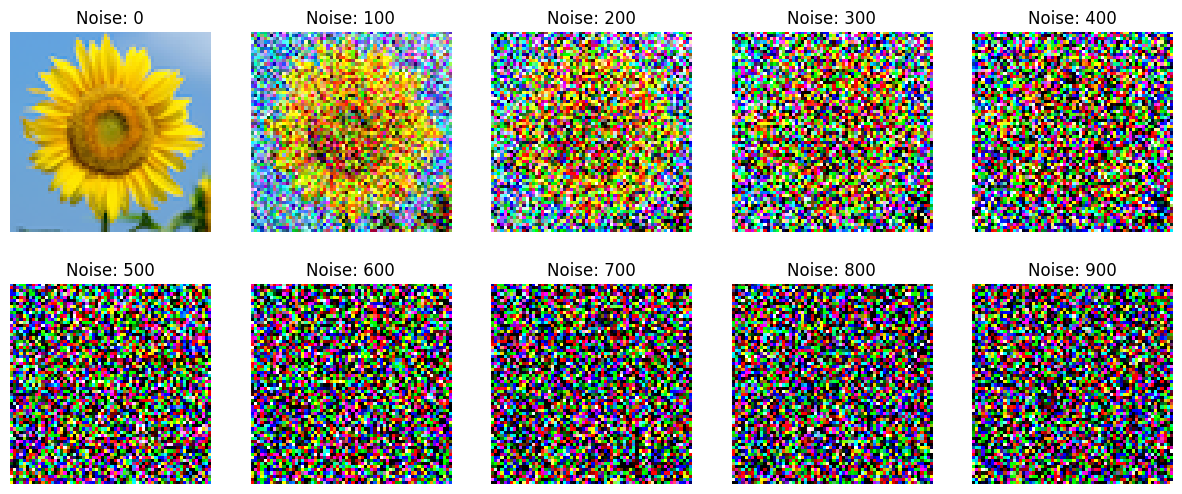

In [15]:
# 画像データに対して拡散過程を適用
T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T) 
imgs = []

for t in range(T):
    if t % 100 == 0:
        img = reverse_to_img(x)  # TensorをPIL画像に変換
        imgs.append(img) 
    
    beta = betas[t]
    eps = torch.randn_like(x)  # xと同じ形状のガウスノイズを生成
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps  # ノイズを加える

# 10個の画像を2行5列で表示
plt.figure(figsize=(15, 6))
for i, img in enumerate(imgs[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Noise: {i * 100}")
    plt.axis('off')

plt.show()

- 1ステップずつのノイズ追加をループでT回繰り返し, 100ステップごとに画像を保存して可視化する.  
- 可視化結果では, ステップが進むにつれて画像が徐々に完全なノイズに近づいていく様子が確認できる.  最後の方は, 完全なノイズとなっている.
---

### 9.3.3 q(xt | x0) からのサンプリング

> **ハイパーパラメータの関係式** 
> $$
> \alpha_t = 1 - \beta_t
> $$
> $$
> \bar{\alpha}_t = \prod_{i=1}^{t} \alpha_i
> $$
>
> **確率分布: $q(x_t | x_0)$**
> $$
> q(\mathbf{x}_t | \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t}\mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
> $$
>
> **$q(x_t | x_0)$ からのサンプリング** 
> $$
> \epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \\ 
> \mathbf{x}_t = \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon
> $$

$\Rightarrow$ **元の画像 $x_0$ から任意の時刻 $t$ のノイズ画像 $x_t$を直接計算** できる! 

$\bar{\alpha}_t$の計算には, テンソルの **累積積(Cummulative Product)** を計算する`torch.cumprod()`関数が使用される.  今回は, 1次元のテンソルのみを扱うのでdim=0とする. 

In [16]:
# output = torch.cumprod(input, dim=0)

In [17]:
# 具体例: 1次元テンソルの累積積を計算 
import torch 
x = torch.tensor([1,2,3,4])
output = torch.cumprod(x, dim=0)
print(output)  # tensor([  1,   2,   6,  24])

tensor([ 1,  2,  6, 24])


この処理を`add_noise()`関数として実装する. 

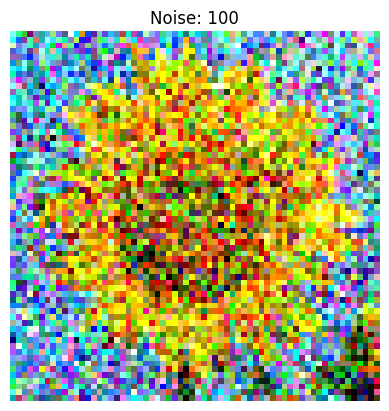

In [18]:
file_path = "flower.png"
img = plt.imread(file_path)
x = preprocess(img)

T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, 1000)  # βを生成

def add_noise(x_0, t, betas):
    T = len(betas)
    assert t >= 1 and t <= T    # 引数tが1からTの範囲内であることを確認

    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    t_idx = t - 1  # リストやテンソルは0から始まるので, インデックスはt-1
    alpha_bar = alpha_bars[t_idx]

    eps = torch.randn_like(x_0) 
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps
    return x_t  # 時刻tのノイズ画像 

# 時刻100のノイズ画像を生成
t = 100
x_t = add_noise(x, t, betas)

# ノイズ画像を表示
img = reverse_to_img(x_t) 
plt.imshow(img)
plt.title(f'Noise: {t}')
plt.axis('off')
plt.show()

`eps = torch.randn_like(x_0)` では, 次の計算式を実装; 
> $$
> \epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \\ 
> \mathbf{x}_t = \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon
> $$

但し、$\alpha_t = 1-\beta_t, \bar{\alpha_t}=\alpha_t \alpha_{t-1}\cdots\alpha_1$と定める(p.196). 

**累積積による恩恵**

100回のループ処理によるノイズ追加をせずに, 一度のノイズ追加のみで拡散過程を表現できた! 

---

### 9.3.4 Diffuser クラスの実装
これまでに実装した拡散過程のコードを, `Diffuser`クラスにまとめる. 下記の通り, 一部コードを変更; 
- GPUへの対応 : 設定に応じてCPUもしくはGPU上で動作させる.
- バッチデータ : データの形状は`(C, H, W)`ではなく`(N, C, H, W)`のデータを扱う

In [19]:
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        """
        時刻tのノイズ画像を生成するメソッド.
        x_0: 元の画像
        t: 時刻 (1からnum_timestepsまで)
        """
        T = self.num_timesteps
        assert (t>=1).all() and (t<=self.num_timesteps).all()   # tの各要素が1以上かつT以下であることを確認
        t_idx = t - 1

        alpha_bar = self.alpha_bars[t_idx]
        N = alpha_bar.shape[0]  # バッチサイズ
        alpha_bar = alpha_bar.view(N, 1, 1, 1)  # 後の計算でブロードキャストできるように整形

        noise = torch.randn_like(x_0, device=self.device)  # 元の画像と同じ形状のノイズを生成
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t # 時刻tのノイズ画像


- `__init__`メソッド:
    - クラスの初期化時に, $\beta_t$, $\alpha_t$, $\bar{\alpha}_t$などのハイパーパラメータをあらかじめ計算し, 指定されたデバイス（CPUまたはGPU）上にテンソルとして保持する. 
- `add_noise`メソッド:
    - 単一画像だけでなくバッチデータ（形状 `(N, C, H, W)`）を扱える.  
    - バッチデータに対する計算でブロードキャストが正しく機能するように, 形状が`(N,)`である`alpha_bar`テンソルを`(N, 1, 1, 1)`に整形する処理を追加.

---

### 9.4 データ生成
**拡散モデルのデータ生成手法**

> 1. $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
> 1. for $t = [T, \dots, 1$]:
> 1. $\quad$ $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ 
> 1. $\quad$ if $t = 1$ then $\epsilon = \mathcal{0}$
> 1. $\quad$ $\sigma_q(t) = \sqrt{\frac{(1-\alpha_t)(1-\bar{\alpha_{t-1}})}{\bar{\alpha_{t}}}}$
> 1.  $\quad \mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t) \right) + \sigma_q(t) \epsilon$
> 1.  return $\mathbf{x}_0$

この疑似コードを`Diffuser`クラスに組み込む. 


実装済みの`Diffuser`クラスに, ノイズから画像を生成するための逆拡散過程のメソッドを追加する. 

--- 


### 9.4.1 ワンステップのデノイズ処理
データ生成ループの1ステップ分, つまり$x_t$から$x_{t-1}$を計算する「デノイズ処理」を, `denoise(self, model, x, t)`メソッドとして実装する. 

In [ ]:
class Diffuser:
    # ... 
    
    def denoise(self, model, x, t):
        # Tの要素が1以上T以下であることを確認
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        # ブロードキャストが正しく行われるための設定
        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()    # モデルを「評価モード」に設定
        with torch.no_grad():   # 勾配計算を無効化(メモリ使用量を削減)
            eps = model(x, t)
        model.train()   # モデルを「学習モード」に設定

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # ブール型テンソルを使用して, もともと1だった要素に新しい値0を代入
        

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
        return mu + noise * std

平均$\mu$と標準偏差$\sigma_t$を計算式; 
> **平均$\mu$:** 
> $$\mu = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t) \right)$$
> **標準偏差$\sigma_t$:**
> $$\sigma_t = \sqrt{\frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}}$$

これらを, 時刻`T`からスタートして, 1つずつ前の時刻のデータを生成する. 
完全なノイズ($x_T$)から初めて, 少しずつノイズを取り除き, 最終的にノイズを除去した画像($x_0$)が生成する(p.207). 

---


### 9.4.2 データ生成の実装
続いて, 拡散モデルによって画像を生成するメソッドを`sample(self, model, x_shape)`として実装する. 
- 完全なノイズから画像を生成する全プロセス. 
- 引数の`x_shape`は生成するテンソルの形状. 
    - MNISTを想定した時の形状`(20,1,28,28)`をデフォルト引数として設定しておく. 

In [ ]:
from tqdm import tqdm # プログレスバーを表示するためのライブラリ

class Diffuser:
    #...

    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)

    def sample(self, model, x_shape=(20, 1, 28, 28)):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device) # 生成したい画像の形状`x_shape`に従い, ガウスノイズを生成

        for i in tqdm(range(self.num_timesteps, 0, -1)): # 1
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)   
            x = self.denoise(model, x, t)   # 2

        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]   # 3
        return images

1. `for i in tqdm(range(self.num_timesteps, 0, -1))`
    - `range(self.num_steps, 0, -1)`により, `self.num_steps`から`1`まで1ずつ減らしていく逆順のイテレータを作成.
    - `tqdm()`関数にループするイテレータを渡すことで, ループの進行状況を表示するプログレスバーを作成

2. `self.denoise(model, x, t)`
    - 先ほど実装した`denoise()`メソッドを`for`文の中で繰り返し呼び出す. 
    - ノイズ画像`x`を1ステップずつデノイズしていく（$\mathbf{x}_t \rightarrow \mathbf{x}_{t-1}$）

3. `self.reverse_to_img(x[i])`
    - 最終的に得られたテンソル$\mathbf{x}_0$を, テンソルを表示可能なPILイメージへと変換.
    - そのために, 各バッチのテンソルに対して`reverse_to_img()`メソッドを呼び出す

以上が, `Diffuser`クラスによるデータ生成である. 最後に, `Diffuser`の完全版を示す. 

In [ ]:
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        """
        時刻tのノイズ画像を生成するメソッド.
        x_0: 元の画像
        t: 時刻 (1からnum_timestepsまで)
        """
        T = self.num_timesteps
        assert (t>=1).all() and (t<=self.num_timesteps).all()   # tの各要素が1以上かつT以下であることを確認
        t_idx = t - 1

        alpha_bar = self.alpha_bars[t_idx]
        N = alpha_bar.shape[0]  # バッチサイズ
        alpha_bar = alpha_bar.view(N, 1, 1, 1)  # 後の計算でブロードキャストできるように整形

        noise = torch.randn_like(x_0, device=self.device)  # 元の画像と同じ形状のノイズを生成
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise # 時刻tのノイズ画像とノイズ
    
    def denoise(self, model, x, t):
        # Tの要素が1以上T以下であることを確認
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        # ブロードキャストが正しく行われるための設定
        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()    # モデルを「評価モード」に設定
        with torch.no_grad():   # 勾配計算を無効化(メモリ使用量を削減)
            eps = model(x, t)
        model.train()   # モデルを「学習モード」に設定

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # ブール型テンソルを使用して, もともと1だった要素に新しい値0を代入

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
        return mu + noise * std
    
    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)

    def sample(self, model, x_shape=(20, 1, 28, 28)):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device) # 生成したい画像の形状`x_shape`に従い, ガウスノイズを生成

        for i in tqdm(range(self.num_timesteps, 0, -1)): # 1
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)   
            x = self.denoise(model, x, t)   # 2

        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]   # 3
        return images

## 9.5 拡散モデルの学習（実装編）
これまでに実装した`Diffuser`クラスと`UNet`クラスを用いて, 拡散モデルの学習とデータ生成を行う.  拡散モデルの学習は, 以下の擬似コードで表されるアルゴリズムに基づいて実装される. 

> **拡散モデルの学習アルゴリズム**
> 1.  Repeat:
> 2.  $\quad \mathbf{x}_0 \sim q(\mathbf{x}_0)$ （学習データより$\mathbf{x}_0$をランダムに取得）
> 3.  $\quad t \sim U\{1, T\}$ （一様分布より整数`t`を生成）
> 4.  $\quad \boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
> 5.  $\quad \mathbf{x}_t = \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}$
> 6.  $\quad ||\boldsymbol{\epsilon} - \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)||^2$ を求め, 勾配法でパラメータを更新

これを実装する. 

---

### 9.5.1 拡散モデルの学習コード
まずは, インポート文とハイパーパラメータの設定, そして画像を表示する関数のコード; 

In [52]:
import math
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm

img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
import torch
print(torch.cuda.is_available())  # TrueになればOK
print(torch.cuda.device_count())  # GPUの枚数
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA")



def show_images(images, rows=2, cols=10):
    """
    画像をグリッド形式で表示する関数.
    images: 画像のリストまたは配列
    rows: 行数
    cols: 列数
    """
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap='gray')
            plt.axis('off') # 軸を非表示にする
            i += 1
    plt.show()

Using device: cuda
True
1
NVIDIA GeForce RTX 4070


In [53]:
preprocess = transforms.ToTensor()  # PIL画像をTensorに変換
dataset = torchvision.datasets.MNIST( # MNISTデータセットをダウンロードしてTensorに変換
    root='./data', train=True, download=True, transform=preprocess  
)
dataloader = DataLoader( # データをシャッフルしてバッチを生成 
    dataset, batch_size=batch_size, shuffle=True 
)
diffuser = Diffuser(num_timesteps, device=device)  # Diffuserクラスのインスタンスを作成
model = UNet()
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)  # モデルのパラメータを最適化するAdamオプティマイザを作成

 **準備**:
- 学習に必要なライブラリ（`torch`, `torchvision`, `matplotlib`など）をインポートする. 
- `batch_size`, `num_timesteps`, `epochs`などのハイパーパラメータを設定する. 
- `device`は, 現在の環境にGPUが利用可能であればデバイスをGPU(`cuda`)とし, そうでなければCPU(`cpu`)に設定
- 学習データとしてMNISTデータセットを用意し, `DataLoader`を作成する. 
- これまでに作成した`Diffuser`クラスと`UNet`クラスをインスタンス化し, `Adam`オプティマイザを設定する. 

100%|██████████| 1000/1000 [00:05<00:00, 166.68it/s]


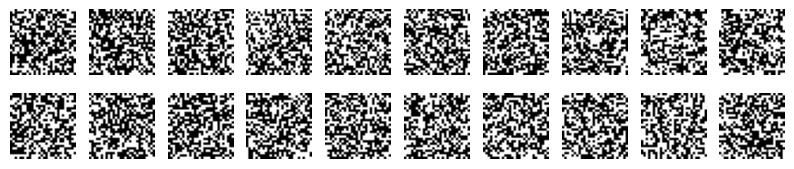

100%|██████████| 469/469 [00:26<00:00, 17.64it/s]


Epoch 0 | Loss: 0.0450795621418559


100%|██████████| 1000/1000 [00:05<00:00, 178.03it/s]


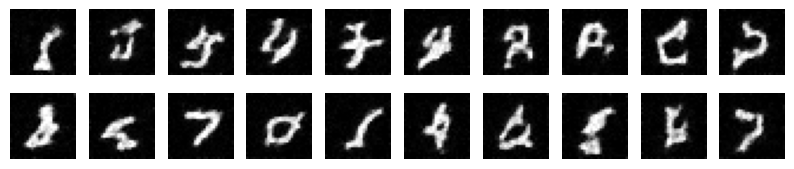

100%|██████████| 469/469 [00:26<00:00, 17.80it/s]


Epoch 1 | Loss: 0.02639733709251957


100%|██████████| 1000/1000 [00:05<00:00, 168.83it/s]


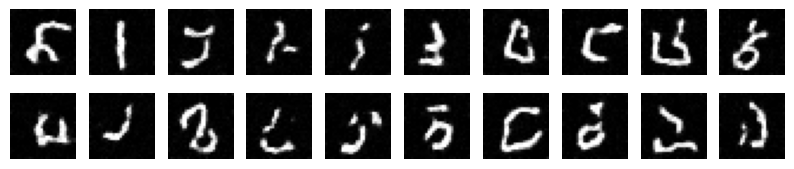

100%|██████████| 469/469 [00:28<00:00, 16.58it/s]


Epoch 2 | Loss: 0.023352378141333553


100%|██████████| 1000/1000 [00:06<00:00, 145.24it/s]


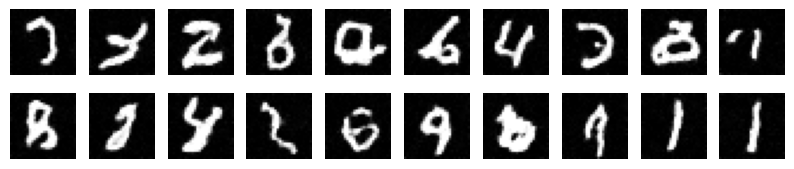

100%|██████████| 469/469 [00:28<00:00, 16.23it/s]


Epoch 3 | Loss: 0.02185520023179016


100%|██████████| 1000/1000 [00:06<00:00, 151.03it/s]


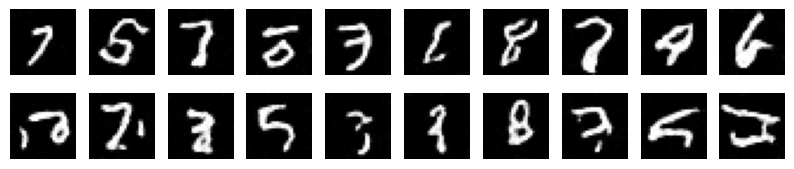

100%|██████████| 469/469 [00:28<00:00, 16.36it/s]


Epoch 4 | Loss: 0.02040232939403385


100%|██████████| 1000/1000 [00:06<00:00, 157.85it/s]


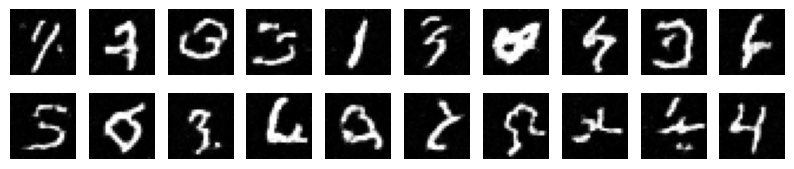

100%|██████████| 469/469 [00:28<00:00, 16.53it/s]


Epoch 5 | Loss: 0.019601749331712215


100%|██████████| 1000/1000 [00:06<00:00, 162.21it/s]


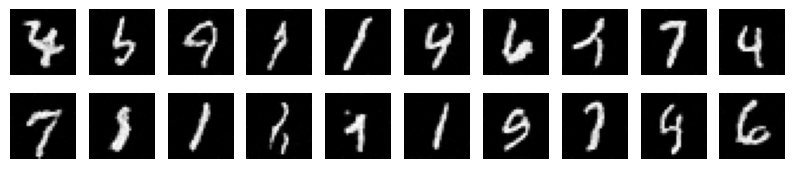

100%|██████████| 469/469 [00:28<00:00, 16.51it/s]


Epoch 6 | Loss: 0.01913619931064435


100%|██████████| 1000/1000 [00:06<00:00, 151.43it/s]


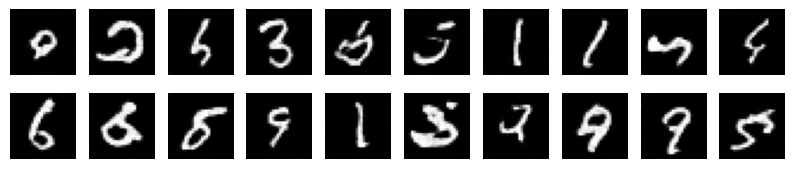

100%|██████████| 469/469 [00:29<00:00, 15.91it/s]


Epoch 7 | Loss: 0.018502103313724243


100%|██████████| 1000/1000 [00:06<00:00, 150.91it/s]


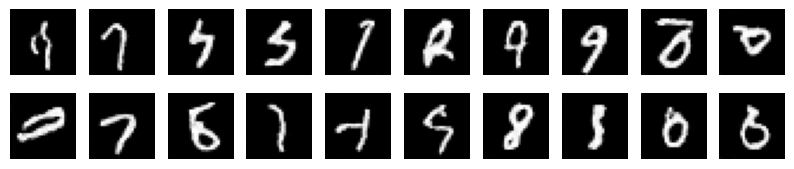

100%|██████████| 469/469 [00:29<00:00, 16.10it/s]


Epoch 8 | Loss: 0.018034325370481656


100%|██████████| 1000/1000 [00:06<00:00, 149.34it/s]


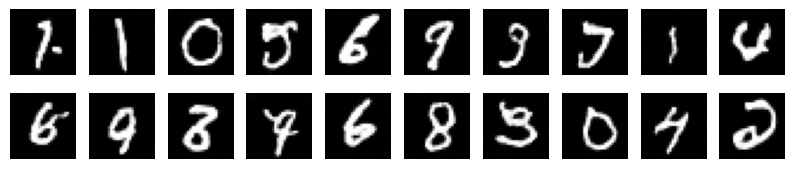

100%|██████████| 469/469 [00:28<00:00, 16.68it/s]


Epoch 9 | Loss: 0.01793594351971645


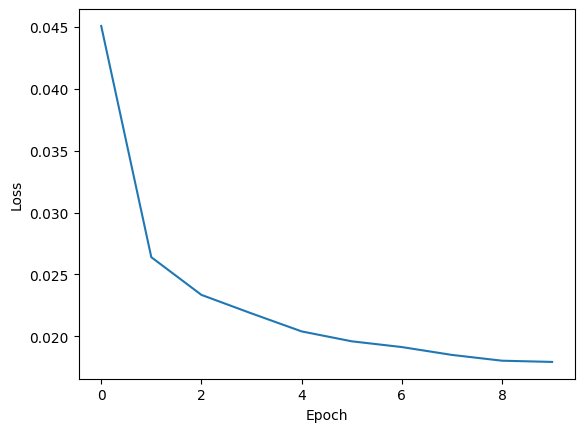

100%|██████████| 1000/1000 [00:06<00:00, 161.04it/s]


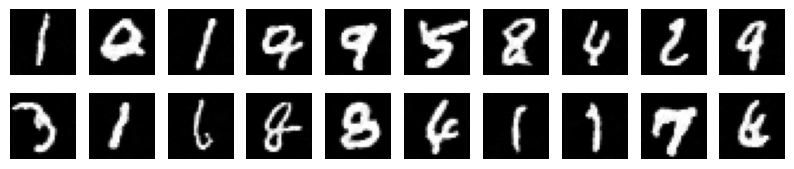

In [ ]:
losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    # エポックごとにデータ生成して結果を確認したい場合は下記のコメントアウトを取る
    images = diffuser.sample(model)
    show_images(images)

    for images, labels in tqdm(dataloader): # 1. プログレスバーのtqdmを使用してdataloaderから画像とラベルを取得
        optimizer.zero_grad()   # 勾配を初期化
        x = images.to(device)   # 画像をデバイスに転送
        t = torch.randint(1, num_timesteps+1, (len(x),), device=device) # 2. 1からTまでのランダムな時刻tを生成

        x_noisy, noise = diffuser.add_noise(x, t)   # 3. ノイズを加えた画像と元のノイズを生成
        noise_pred = model(x_noisy, t)              # 4. U-Netモデルを使用してノイズを予測
        loss = F.mse_loss(noise, noise_pred)        # 5. ノイズ予測と元のノイズの平均二乗誤差を計算

        loss.backward()     # 6. 勾配を計算
        optimizer.step()    # 7. モデルのパラメータを更新

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

    # エポックごとにパラメータを保存
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_avg,
    }, f'checkpoint_epoch{epoch}_batchsize{batch_size}_num-timesteps{num_timesteps}_lr{lr}_.pth')

# plot losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 画像生成＆表示
images = diffuser.sample(model)
show_images(images)

#### モデルの学習ループ

**拡散過程(問題を作る)**

1. `dataloader`からミニバッチ単位で学習画像$\mathbf{x}$（$x_0$に相当）を取り出す.  
2. バッチ内の各画像に対し, `torch.randint()`を用いて`1`から`T`（`num_timesteps`）までの整数`t`をランダムにサンプリングする.  
3. `diffuser.add_noise(x, t)`を呼び出し, 学習アルゴリズムのステップ5に基づいてノイズ画像$\mathbf{x}_t$（`x_noisy`）と, 実際に使われたノイズ$\boldsymbol{\epsilon}$（`noise`）を生成させる.  

**順伝播(問題を解かせる)**

4. ノイズ画像`x_noisy`と時刻`t`をU-Netモデルに入力し, ノイズ $\boldsymbol{\epsilon}_\theta$（`noise_pred`）を予測させる. 

**損失計算**

5. 損失関数として, 実際のノイズ`noise`とモデルの予測`noise_pred`との間の**平均二乗誤差（MSE）**を`F.mse_loss()`で計算する.  

**逆伝播・最適化**

6. 計算した損失に基づき, `loss.backward()`で勾配を計算する. 
7. `optimizer.step()`でモデルのパラメータを更新する.  

---

### ★ 結局, 拡散モデルでは何をしているのか？ 
$\Rightarrow$ **「ノイズの除去」** をすることで画像生成を行っている!
#### 0. 学習
上記「モデルの学習ループ」を参照. 
#### 1.ランダムノイズの生成
まず, 生成したい画像のサイズ(MNISTの場合は28x28ピクセル)で, 完全にランダムなノイズ画像を生成する(`torch.randn()`により). この時点では, 画像には元データの情報などは全く含まれていない.
#### 2. ノイズ除去の反復
次に, 学習済みのU-Netモデルを使って, このノイズ画像から少しずつノイズを取り除いていく作業を繰り返す. ここでは, 拡散過程の時間ステップ(`num_time_step`)を逆向きに(`1000`から`1`へ)たどる. これが, **逆拡散過程**に相当. 
- ノイズの予測 : 現在の画像に含まれているノイズを予測.
- ノイズの除去 : 予測されたノイズを, 現在の画像から引き算. 
#### 3. 最終的な画像の生成
これら「ノイズの予測と除去」のステップを時間ステップが`1`になるまで繰り返すことで, ただのノイズだった画像が, 徐々に"意味のある"画像(ここでは手書き数字)へと変化する. 

---

### 9.5.2 学習結果
- **損失関数の推移**:
    - 学習の進行に伴い, 損失関数の値はエポックを重ねるごとに減少していく. これは学習が正常に進んでいることを示す. 

**Epoch = 0~9 まで**

![](loss_trantision.png)

**Epoch = 0~19 まで**

![](loss_trantision2.png)

- **生成画像の変化**:
    - 学習中の各エポックで生成した画像を見ると, 最初はランダムなノイズであったものが, エポックが進むにつれて手書き数字へと変化していく様子が確認できる.  
    - 学習後のモデルによって生成された画像は, 学習データに近い品質の手書き数字となる.  
    - 画像の質は, 学習データを増やす, モデルを改善する, ハイパーパラメータを調整する, といったことによってさらに向上する可能性がある.  

---

#### `num_timesteps = 2000`へと変更した場合

![](loss_trantision_num-timesteps2000.png)


--- 

#### `num_timesteps = 4000`へと変更した場合

![](loss_trantision_num-timesteps4000.png)

--- 

#### `num_timesteps = 6000`へと変更した場合

![](loss_trantision_num-timesteps6000.png)



Restoring from checkpoint...


C:\Users\kyoro\AppData\Local\Temp\ipykernel_36916\3530448240.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

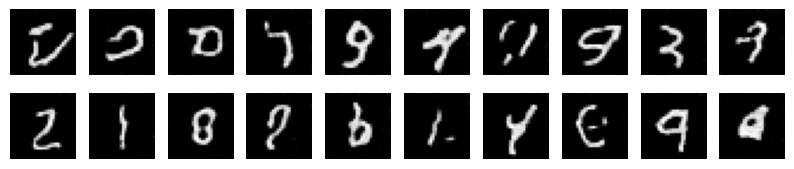

In [ ]:
# --- チェックポイントから画像生成 ----

RECOVER_EPOCH = 9  # 復元するエポック番号
PRAM_SETS_NUMBER = 2    # 復元するパラメータセットのインデックス

# パラメータセット
param_sets = [
    {
        "batch_size": 128,
        "num_timesteps": 1000,
        "lr": 0.001
    },
    {
        "batch_size": 128,
        "num_timesteps": 2000,
        "lr": 0.001
    },
    {
        "batch_size": 128,
        "num_timesteps": 6000,
        "lr": 0.001
    }
]

print("Restoring from checkpoint...")

# --- パラメータセットから値を取得 ---
params = param_sets[PRAM_SETS_NUMBER]
batch_size = params["batch_size"]
num_timesteps = params["num_timesteps"]
lr = params["lr"]

# --- チェックポイントから復元 ---
checkpoint_path = f'checkpoint_epoch{RECOVER_EPOCH}_batchsize{batch_size}_num-timesteps{num_timesteps}_lr{lr}_.pth'

model = UNet()
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])                                                                                                                                                                                                 
model.eval()
                              
                                                                                                                                          
images = diffuser.sample(model)
show_images(images)